### MobileNetV2 Grad-CAM and FGSM Adversarial Attack Visualization



In [38]:
# Import necessary libraries
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image
from PIL import Image


### Load and Display Original Image


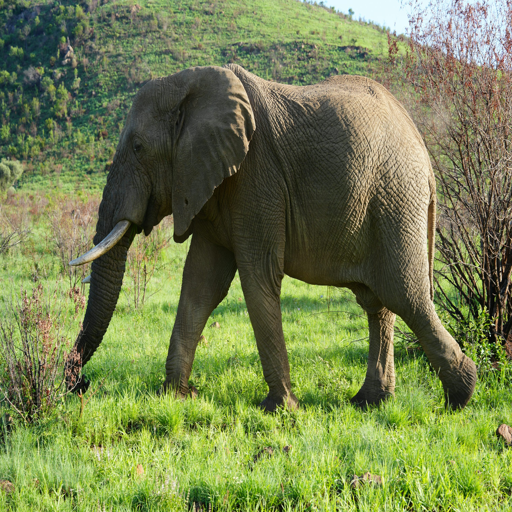

In [39]:
# The local path to our target image
img_path = "elephant.jpg"
img = Image.open(img_path)

img_resized = img.resize((512, 512))
display(img_resized)



### Load Pre-trained MobileNetV2 Model and Preprocess Image


In [40]:
model = MobileNetV2(weights="imagenet")

img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)


### Predict on Original Image and Display Top-5 Classes


In [41]:
predictions = model.predict(img_array)
predicted_class = np.argmax(predictions[0])
print("Original image predictions:")
print(decode_predictions(predictions, top=5)[0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Original image predictions:
[('n02504458', 'African_elephant', 0.65579474), ('n01871265', 'tusker', 0.18810661), ('n02504013', 'Indian_elephant', 0.008544292), ('n02410509', 'bison', 0.0019396566), ('n02397096', 'warthog', 0.001437883)]


### Grad-CAM Setup and Compute Heatmap for Original Image


In [42]:
last_conv_layer = model.get_layer("out_relu")
grad_model = tf.keras.Model([model.inputs], [last_conv_layer.output, model.output])

img_tensor = tf.convert_to_tensor(img_array)
with tf.GradientTape() as tape:
    conv_output, predictions = grad_model(img_tensor)
    class_score = predictions[:, predicted_class]

gradients = tape.gradient(class_score, conv_output)
pooled_gradients = tf.reduce_mean(gradients, axis=(0, 1, 2))

conv_output = conv_output[0]
heatmap = conv_output * pooled_gradients
heatmap = tf.reduce_mean(heatmap, axis=-1).numpy()

heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap) + 1e-8
heatmap_resized = tf.image.resize(heatmap[..., np.newaxis], (224, 224)).numpy()
heatmap_resized = np.squeeze(heatmap_resized)


c:\Users\Israil\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor_5449']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


### Generate FGSM Adversarial Image


In [43]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
label = np.argmax(model.predict(img_array))
input_tensor = tf.convert_to_tensor(img_array)

with tf.GradientTape() as tape:
    tape.watch(input_tensor)
    prediction = model(input_tensor)
    loss = loss_object(tf.constant([label]), prediction)

gradient = tape.gradient(loss, input_tensor)
signed_grad = tf.sign(gradient)
epsilon = 0.05
adv_img = input_tensor + epsilon * signed_grad
adv_img = tf.clip_by_value(adv_img, -1.0, 1.0)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


### Function to Deprocess Images for Visualization


In [44]:
def deprocess(img_tensor):
    img = (img_tensor + 1.0) * 127.5
    img = np.clip(img, 0, 255).astype(np.uint8)
    return img

original_img_display = deprocess(img_array[0].astype(np.float32))
adv_img_display = deprocess(adv_img[0].numpy())


### Predict and Display Top-5 Classes for Adversarial Image


In [45]:
adv_predictions = model.predict(adv_img)
adv_predicted_class = np.argmax(adv_predictions[0])
print("\nAdversarial image predictions:")
print(decode_predictions(adv_predictions, top=5)[0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step

Adversarial image predictions:
[('n01871265', 'tusker', 0.67338747), ('n02504013', 'Indian_elephant', 0.110431954), ('n02504458', 'African_elephant', 0.010953186), ('n02095570', 'Lakeland_terrier', 0.0065063634), ('n02396427', 'wild_boar', 0.0060876654)]


### Compute Grad-CAM Heatmap for Adversarial Image


In [46]:
with tf.GradientTape() as tape_adv:
    conv_output_adv, predictions_adv = grad_model(adv_img)
    class_score_adv = predictions_adv[:, adv_predicted_class]

gradients_adv = tape_adv.gradient(class_score_adv, conv_output_adv)
pooled_gradients_adv = tf.reduce_mean(gradients_adv, axis=(0, 1, 2))

conv_output_adv = conv_output_adv[0]
heatmap_adv = conv_output_adv * pooled_gradients_adv
heatmap_adv = tf.reduce_mean(heatmap_adv, axis=-1).numpy()

heatmap_adv = np.maximum(heatmap_adv, 0)
heatmap_adv /= np.max(heatmap_adv) + 1e-8
heatmap_resized_adv = tf.image.resize(heatmap_adv[..., np.newaxis], (224, 224)).numpy()
heatmap_resized_adv = np.squeeze(heatmap_resized_adv)


### Visualization 

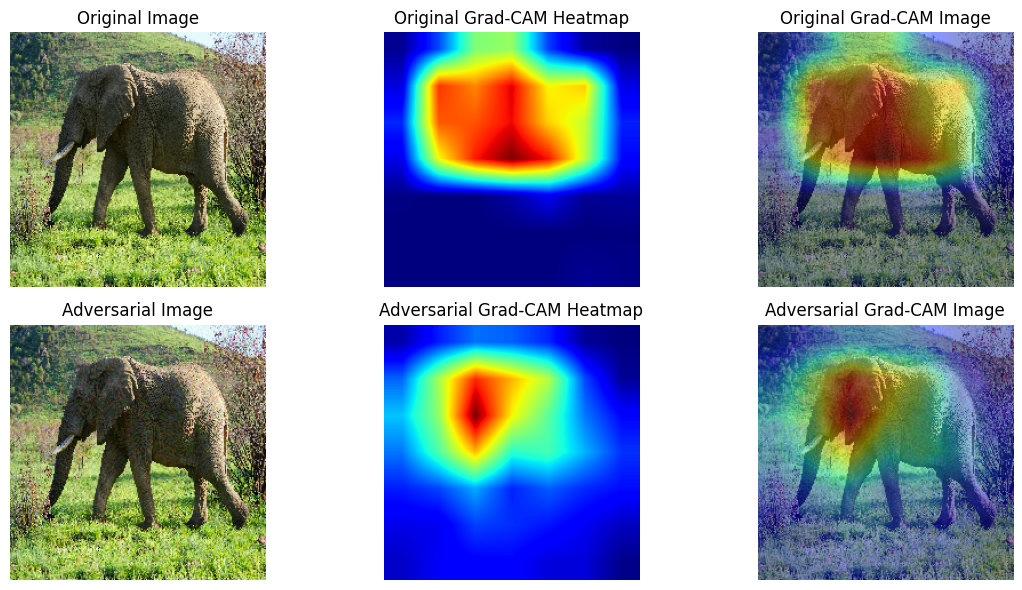

In [50]:
plt.figure(figsize=(12, 6))

plt.subplot(2, 3, 1)
plt.imshow(original_img_display)
plt.title("Original Image")
plt.axis('off')

plt.subplot(2, 3, 2)
plt.imshow(heatmap_resized, cmap='jet')
plt.title("Original Grad-CAM Heatmap")
plt.axis('off')

plt.subplot(2, 3, 3)
plt.imshow(original_img_display)
plt.imshow(heatmap_resized, cmap='jet', alpha=0.4)
plt.title("Original Grad-CAM Image")
plt.axis('off')

plt.subplot(2, 3, 4)
plt.imshow(adv_img_display)
plt.title("Adversarial Image")
plt.axis('off')

plt.subplot(2, 3, 5)
plt.imshow(heatmap_resized_adv, cmap='jet')
plt.title("Adversarial Grad-CAM Heatmap")
plt.axis('off')

plt.subplot(2, 3, 6)
plt.imshow(adv_img_display)
plt.imshow(heatmap_resized_adv, cmap='jet', alpha=0.4)
plt.title("Adversarial Grad-CAM Image")
plt.axis('off')

plt.tight_layout()
plt.show()


### IG visualization 

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Original image predictions:
[('n02504458', 'African_elephant', 0.65579474), ('n01871265', 'tusker', 0.18810661), ('n02504013', 'Indian_elephant', 0.008544292), ('n02410509', 'bison', 0.0019396566), ('n02397096', 'warthog', 0.001437883)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   

Adversarial image predictions:
[('n01871265', 'tusker', 0.67338747), ('n02504013', 'Indian_elephant', 0.110431954), ('n02504458', 'African_elephant', 0.010953186), ('n02095570', 'Lakeland_terrier', 0.0065063634), ('n02396427', 'wild_boar', 0.0060876654)]


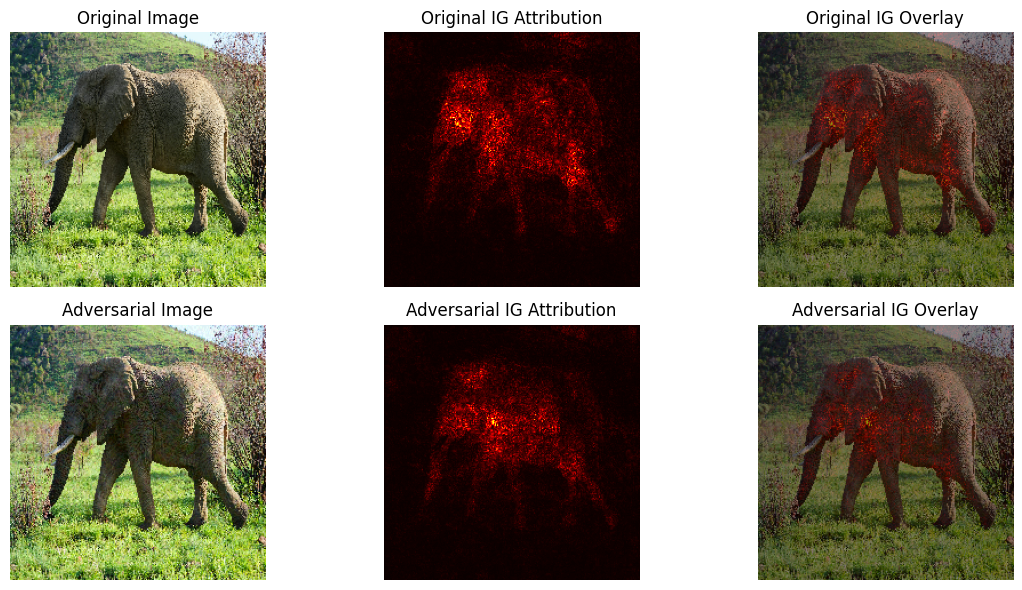

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image
from PIL import Image

# ==========Load and display image =============
img_path = "elephant.jpg"
img = Image.open(img_path)
img_resized = img.resize((512, 512))
# display(img_resized) 

# =============Load pre-trained model and preprocess image ==============
model = MobileNetV2(weights="imagenet")
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)

#==========Predict on original image ===================
predictions = model.predict(img_array)
predicted_class = np.argmax(predictions[0])
print("Original image predictions:")
print(decode_predictions(predictions, top=5)[0])

# =============Integrated Gradients ==============
def integrated_gradients(model, img_input, target_index, baseline=None, steps=50):
    if baseline is None:
        baseline = tf.zeros(shape=img_input.shape)

    img_input = tf.squeeze(img_input)     
    baseline = tf.squeeze(baseline)       
    alphas = tf.linspace(0.0, 1.0, steps + 1)
    interpolated = [(baseline + alpha * (img_input - baseline)) for alpha in alphas]
    interpolated = tf.stack(interpolated) 
    interpolated = tf.cast(interpolated, tf.float32)

    with tf.GradientTape() as tape:
        tape.watch(interpolated)
        preds = model(interpolated)
        target_preds = preds[:, target_index]

    grads = tape.gradient(target_preds, interpolated)  
    avg_grads = tf.reduce_mean(grads[:-1], axis=0)     

    ig = (img_input - baseline) * avg_grads
    return ig.numpy()


# =================IG on original image ======================
img_tensor = tf.convert_to_tensor(img_array)
attributions = integrated_gradients(model, img_tensor, predicted_class)
ig_norm = np.sum(np.abs(attributions), axis=-1)
ig_norm = ig_norm / (np.max(ig_norm) + 1e-8)

# =================FGSM adversarial attack ========================
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
input_tensor = tf.convert_to_tensor(img_array)

with tf.GradientTape() as tape:
    tape.watch(input_tensor)
    prediction = model(input_tensor)
    loss = loss_object(tf.constant([predicted_class]), prediction)

gradient = tape.gradient(loss, input_tensor)
signed_grad = tf.sign(gradient)
epsilon = 0.05
adv_img = input_tensor + epsilon * signed_grad
adv_img = tf.clip_by_value(adv_img, -1.0, 1.0)

# =============Predict on adversarial image ===================
adv_predictions = model.predict(adv_img)
adv_predicted_class = np.argmax(adv_predictions[0])
print("\nAdversarial image predictions:")
print(decode_predictions(adv_predictions, top=5)[0])

# ===================IG on adversarial image =======================
adv_ig = integrated_gradients(model, adv_img, adv_predicted_class)
adv_ig_norm = np.sum(np.abs(adv_ig), axis=-1)
adv_ig_norm = adv_ig_norm / (np.max(adv_ig_norm) + 1e-8)

# ==============Deprocess images for display =======================
def deprocess(img_tensor):
    img = (img_tensor + 1.0) * 127.5
    img = np.clip(img, 0, 255).astype(np.uint8)
    return img

original_img_display = deprocess(img_array[0].astype(np.float32))
adv_img_display = deprocess(adv_img[0].numpy())

# ==========Plot all results ================
plt.figure(figsize=(12, 6))

plt.subplot(2, 3, 1)
plt.imshow(original_img_display)
plt.title("Original Image")
plt.axis('off')

plt.subplot(2, 3, 2)
plt.imshow(ig_norm, cmap='hot')
plt.title("Original IG Attribution")
plt.axis('off')

plt.subplot(2, 3, 3)
plt.imshow(original_img_display)
plt.imshow(ig_norm, cmap='hot', alpha=0.5)
plt.title("Original IG Overlay")
plt.axis('off')

plt.subplot(2, 3, 4)
plt.imshow(adv_img_display)
plt.title("Adversarial Image")
plt.axis('off')

plt.subplot(2, 3, 5)
plt.imshow(adv_ig_norm, cmap='hot')
plt.title("Adversarial IG Attribution")
plt.axis('off')

plt.subplot(2, 3, 6)
plt.imshow(adv_img_display)
plt.imshow(adv_ig_norm, cmap='hot', alpha=0.5)
plt.title("Adversarial IG Overlay")
plt.axis('off')

plt.tight_layout()
plt.show()
